# References

Smalldata_tools documentation: https://confluence.slac.stanford.edu/display/PSDM/small+data%3A+Analysis+tools+for+aligned+data

Generation of h5 files with smalldata_tools: https://confluence.slac.stanford.edu/display/PSDM/1.+Generation+of+the+small+data+hdf5+files

Make ROI with smalldata_tools: https://confluence.slac.stanford.edu/display/PSDM/ROIs+and+Projections

In [1]:
import numpy as np
import sys
import h5py
import tables
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
import socket

from tqdm import tqdm

import sys
from pathlib import Path

# import psana as ps

import ana_fun as ana

In [2]:
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# <font color='orange'> 0) Select run and files </font>

In [150]:
run = 11
exp = 'xppl1001021'

p = Path('/sdf/data/lcls/ds/{}/{}/hdf5/smalldata/'.format(exp[:3], exp))
print(p.exists())

it = p.glob('{}_Run{:04d}*'.format(exp,run))
try:
    f = next(it)
    print(f)
    print('\n')
except: print('No files found at this path.')

# only for example. COMMENT OR DELETE WHEN ANALYZING EXP DATA:
#f = Path('/sdf/data/lcls/ds/xpp/xpptut15/hdf5/smalldata/data_examples/example_run_trXRD.h5')

rr = tables.File(f).root
h5 = h5py.File(f)
print('\n'.join(h5.keys()))

True
/sdf/data/lcls/ds/xpp/xppl1001021/hdf5/smalldata/xppl1001021_Run0011.h5


UserDataCfg
adc
ai
damage
diode2
diodeU
ebeam
epics
event_time
evr
fiducials
gas_detector
ipm2
ipm_hx2
lightStatus
lombpm
lomdiode
scan
tt


In [151]:
# explore h5 file content:

# <font color='orange'> 1) Set and check filters </font>

In [152]:
# helper dict to find data in file
dataDict = {
    #'scanvar': 'enc/lasDelay',
    'i0': 'ipm2/sum',
    #'roi': 'jungfrau1M/ROI_0_area',
    #'xon': 'lightStatus/xray',
    #'lon': 'lightStatus/laser',
    #'lon': 'evr/code_91',
    'tt_corr': 'tt/ttCorr',
    'tt_fwhm': 'tt/FLTPOSFWHM',
    'tt_amp': 'tt/AMPL'
}
#detname = dataDict['roi'].split('/')[0]

filters = {}
#filters['i0'] = [200,4000]
#filters['tt_amp'] = [-1,1]
#filters['tt_fwhm'] = [-1,1000]
#damage = [dataDict['roi'].split('/')[0], dataDict['i0'].split('/')[0]]

print('Filter selection:')
for key,value in filters.items():
	print('\t{} : {}'.format(key, value))
hist_bins = {key: 35 for key in filters.keys()}

Filter selection:


## Plot filters variables

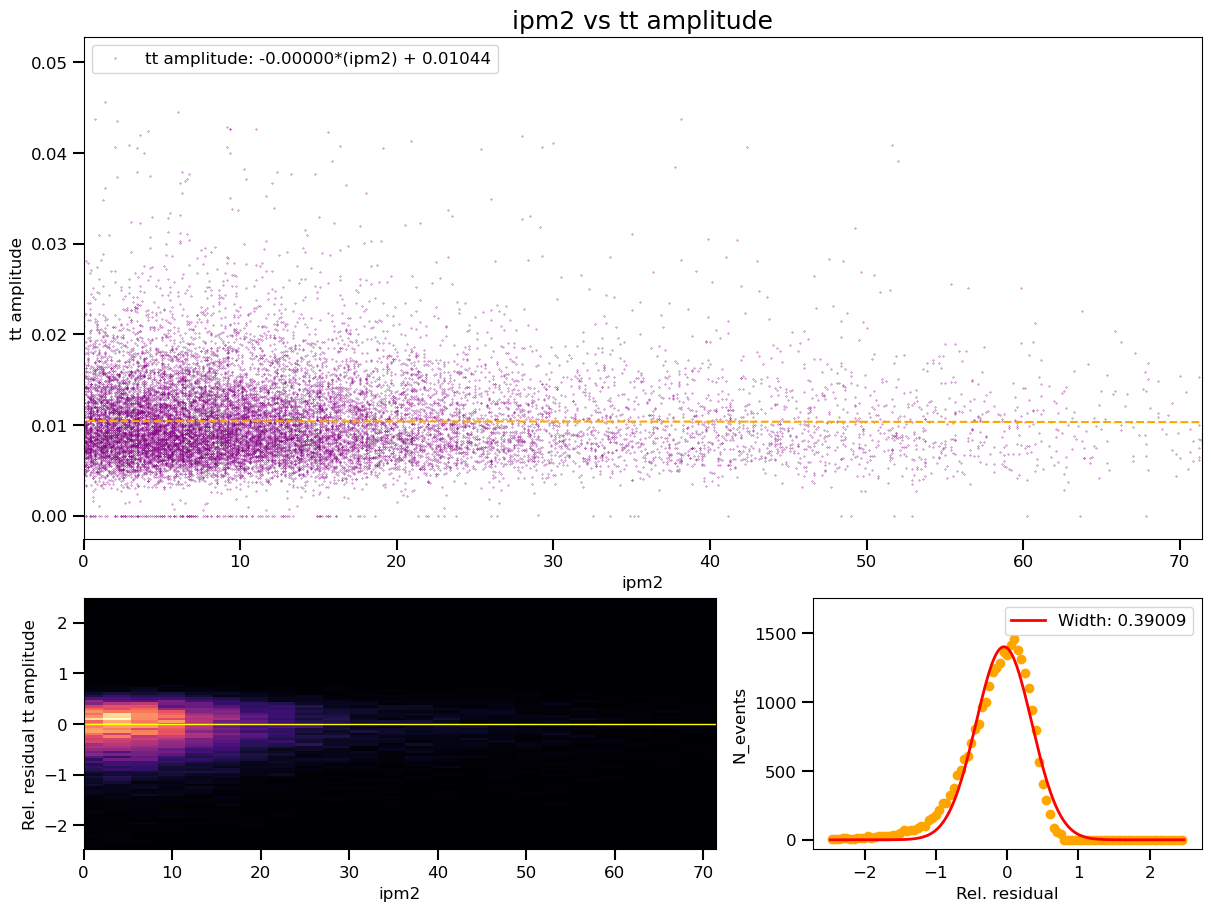

In [153]:
axs, fitRes, fitResG = ana.correlation_residual_plot(rr.ipm2.sum, rr.tt.AMPL , 
                                                     labels=['ipm2','tt amplitude'], 
                                                     axs=None,
                                                     relative_residual=True, 
                                                     use_hist=False)

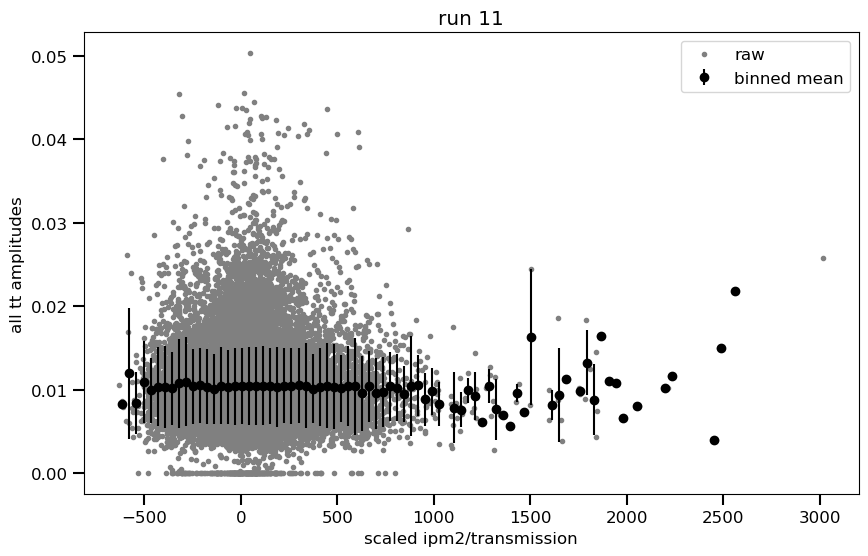

In [154]:
xscale = 0.085

plt.plot(rr.ipm2.sum[:]/xscale, rr.tt.AMPL[:],'.',color='gray',label='raw'); #plt.xlim([0,1000])

x = rr.ipm2.sum[:]
y = rr.tt.AMPL[:]

h, bin_edges = np.histogram(x, bins=100)
b = []; z = []; zunc = []
for i in range(len(bin_edges) - 1):
    low = bin_edges[i]
    high = bin_edges[i + 1]
    ind = np.where((x > low) & (x < high))[0]

    b.append(np.mean([low, high])/xscale)
    z.append(np.mean(y[ind]))
    zunc.append(np.std(y[ind]))

plt.errorbar(b, z, zunc, color='k', linestyle='none', marker='o',label='binned mean')
plt.xlabel('scaled ipm2/transmission')
plt.ylabel('all tt amplitudes')
plt.title("run {}".format(run))
plt.legend()
plt.show()

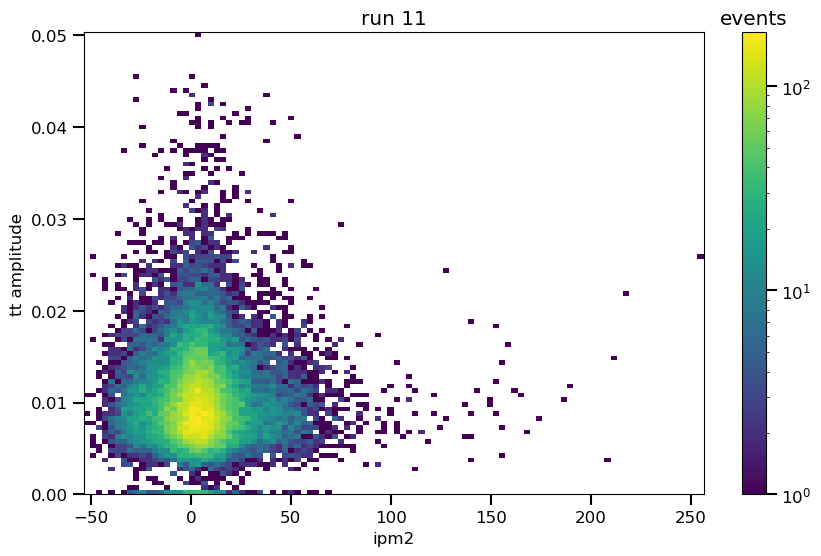

In [155]:
import matplotlib


plt.hist2d(rr.ipm2.sum[:], rr.tt.AMPL[:],norm=matplotlib.colors.LogNorm(), bins=100, \
           range=[[np.min(rr.ipm2.sum),np.max(rr.ipm2.sum)], [0, np.max(rr.tt.AMPL)]])
#plt.errorbar(b, z, zunc, color='k', linestyle='none', marker='o',label='binned mean')
plt.xlabel('ipm2'); plt.ylabel('tt amplitude');
clb = plt.colorbar(); #plt.clim([0, 1000])
clb.ax.set_title('events',loc='center')
plt.title("run {}".format(run))
#plt.legend(loc='upper left')
plt.show()

In [156]:
be,ze,ee = b,z,zunc

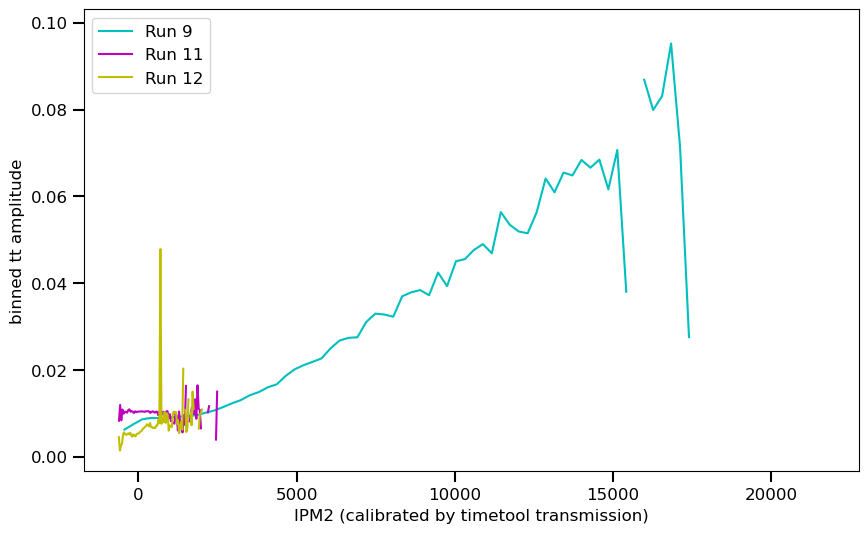

In [160]:
#plt.errorbar(by, zy, ey, color='k', linestyle='none', marker='o',label='YAG')
#plt.errorbar(bl, zl, el, color='r', linestyle='none', marker='o',label='LuAG')
#plt.errorbar(bg, zg, eg, color='b', linestyle='none', marker='o',label='GAGG')

#plt.plot(by, zy, 'k-',label='YAG')
#plt.plot(bl, zl, 'r-',label='LuAG')
#plt.plot(bg, zg, 'b-',label='GAGG')


plt.plot(bn, zn, 'c-',label='Run 9')
#plt.plot(bte, zte, 'm-',label='Run 10')
plt.plot(be, ze, 'm-',label='Run 11')
plt.plot(bt, zt, 'y-',label='Run 12')

plt.xlabel('IPM2 (calibrated by timetool transmission)')
plt.ylabel('binned tt amplitude')
#plt.title("run {}".format(run))
plt.legend()
plt.show()

i0        :  Filter eliminates 23.8% of the shots
tt_amp    :  Filter eliminates 0.0% of the shots
tt_fwhm   :  Filter eliminates 0.0% of the shots


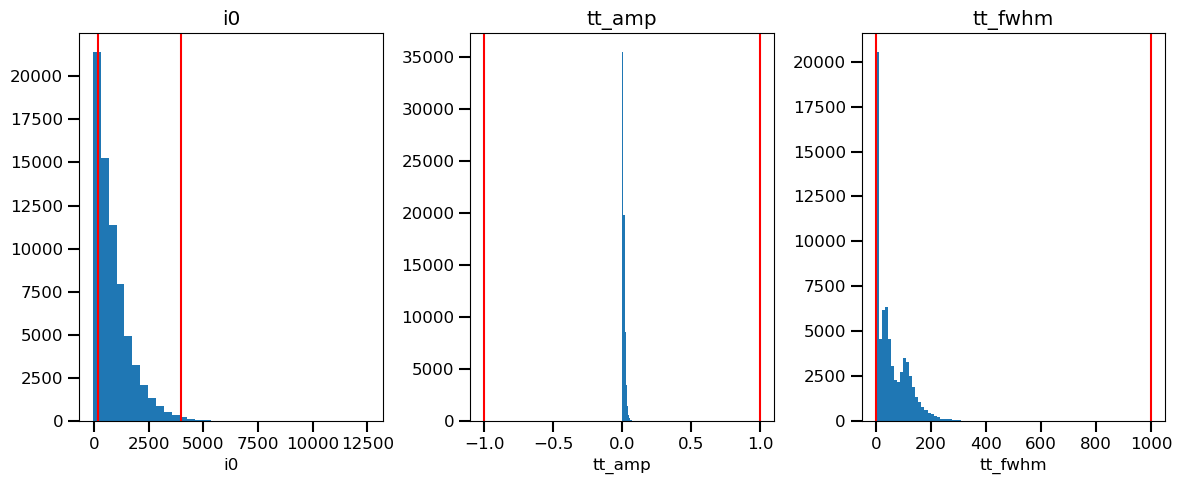

In [7]:
ncols = 3
nrows = len(filters)//ncols
fig, ax = plt.subplots(ncols=3, figsize=(12,5))
hist_bins['tt_fwhm'] = np.linspace(0,320,30)
hist_bins['tt_amp'] = np.linspace(0,0.25,30)
                           
for n, (key,value) in enumerate(filters.items()):
        ax[n].set_title(key)
        ax[n].hist(rr[dataDict[key]], bins=hist_bins[key]) 
        ax[n].set_xlabel(key)
        for ii in range(2):
            ax[n].axvline(value[ii], color='red')
        data = rr[dataDict[key]][:]
        filt = np.logical_and(data > value[0], data < value[1])
        r1 = sum(np.logical_not(filt))/filt.shape[0]
        print('{:10s}:  Filter eliminates {:.1%} of the shots'.format(key,r1))
plt.tight_layout()
plt.show()

# <font color='orange'> 2) Check sum of detector images </font>

Looking at the sum of all images in the run is a good way to make sure that there was no problem at any time during the run.

In [8]:
#llim = 5 # percentile
#ulim = 99

#imageList = [el for el in list(rr.Sums._v_children) if (el.endswith('img') and not 'square' in el)]
#_, ax = plt.subplots(figsize=(10,20), nrows=len(imageList))
#if not isinstance(ax, np.ndarray):
#    ax = [ax]

#for ii, child in enumerate(imageList):
#    im = rr.Sums[child][:]
#    ax[ii].imshow(im, clim=(np.nanpercentile(im, llim),np.nanpercentile(im, ulim)))
#    ax[ii].set_title('{}\nRange= {:.02f}, {:.02f}'.format(child, np.nanpercentile(im, llim), np.nanpercentile(im, ulim) ))
#plt.show()

## Check individual tiles

This is how the detector data are read and saved in the h5 file. Use the tile representation to select the ROI coordinates, as the assebmled imaged is often rotated or even mirrored according the geometry file.

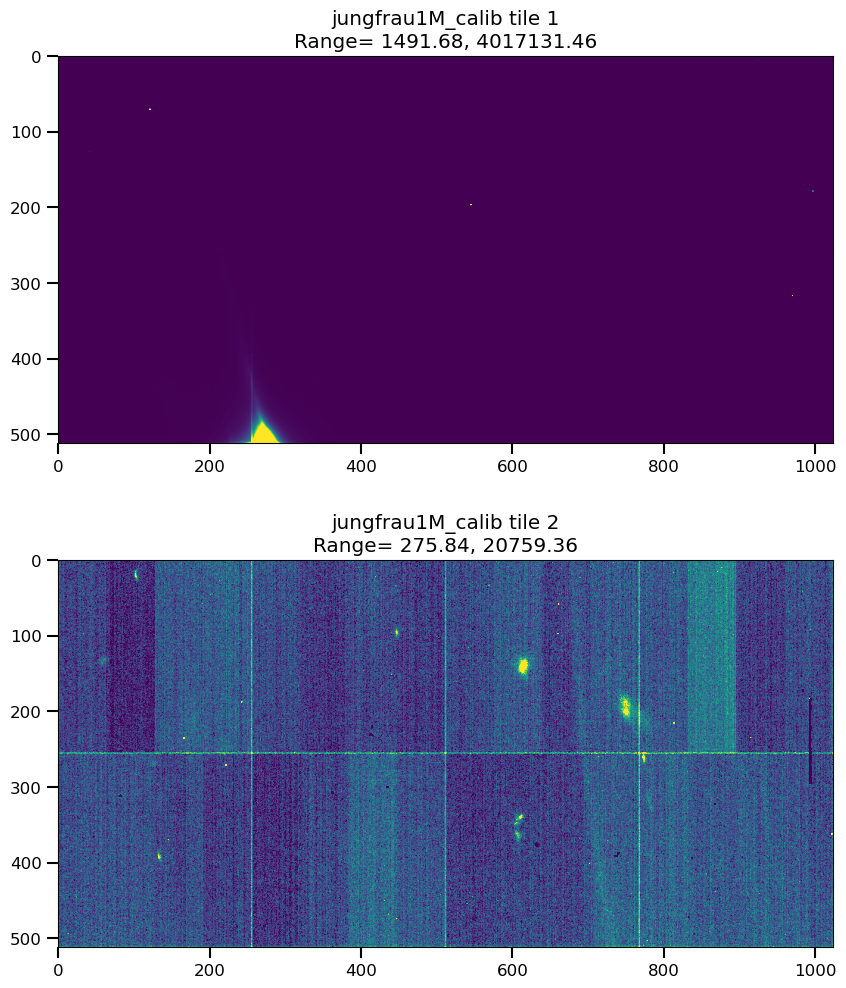

In [9]:
im_tiles_list = [el for el in list(rr.Sums._v_children) if (el.endswith('calib') and not 'square' in el)]

for child in im_tiles_list:
    im_tiles = rr.Sums[child][:]
    if im_tiles.ndim==3:
        ntiles = im_tiles.shape[0]
    else:
        ntiles = 1
        im_tiles= [im_tiles]
    _, ax = plt.subplots(figsize=(10,6*ntiles), nrows=ntiles)
    if not isinstance(ax, np.ndarray):
        ax = [ax]
    for ii,im in enumerate(im_tiles):
        ax[ii].set_title('{} tile {}\nRange= {:.02f}, {:.02f}'.format(child, ii+1, np.nanpercentile(im, 1), np.nanpercentile(im, 99.9) ))
        ax[ii].imshow(im, clim=(np.nanpercentile(im, 5),np.nanpercentile(im, 99.9)))
        ax[ii].imshow(im, clim=(np.nanpercentile(im, 5),np.nanpercentile(im, 99.9)))

# <font color='orange'> 3) Pixel histograms and thresholds </font>

## Thresholds

Important to get rid of that 0-photon peak, which only adds noise.
Use a reasonably low number of events to set threshold and ROI. Then loop over all events to apply threshold and refine the ROI.

Fancier thresholding (multiple threshold, etc) can be implemented, to get rid of fluorescence signal for example.

The calib mask is also read at this step. Note that if different ROIs are to be compared, one must account for the number of masked pixels. The mask will be applied when extracting the refined ROI intensity.

(500, 300)


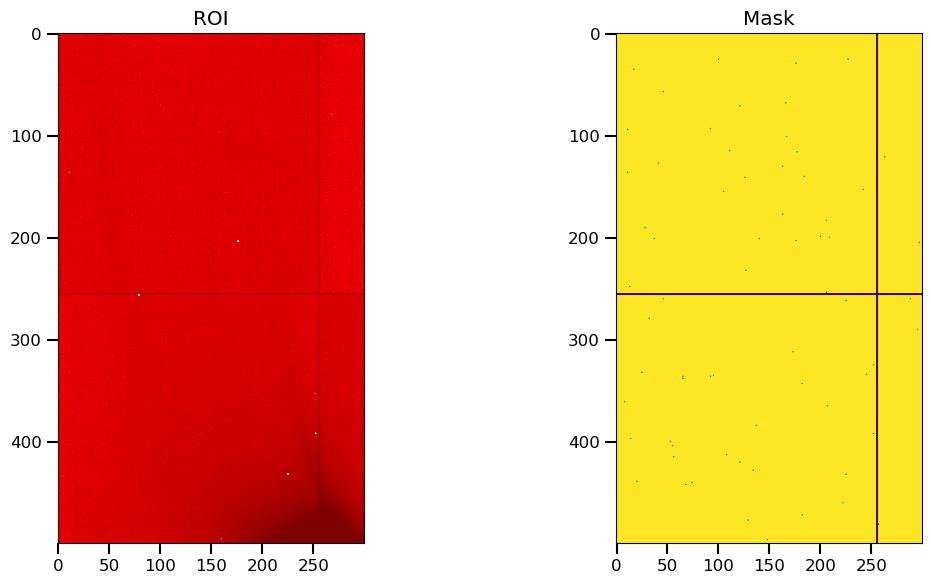

In [37]:
ims = rr[dataDict['roi']][-4000:]
im = ims.sum(axis=0)

# get calib mask for ROI
roi_idx = dataDict['roi'][-6]
roi_mask_field = [v for v in rr.UserDataCfg[detname]._v_children if f'{roi_idx}_mask' in v][0]
mask = np.logical_not(rr.UserDataCfg[detname][roi_mask_field][:]).squeeze()
print(mask.shape)

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
#ax[0].imshow(im, clim=(np.percentile(im, 5),np.percentile(im, 85)), cmap='afmhot')
ax[0].imshow(im, norm=LogNorm(vmin=0.01, vmax=1e4), cmap='jet')
ax[0].set_title('ROI')

ax[1].imshow(mask, clim=(0,1))
ax[1].set_title('Mask')
plt.tight_layout(w_pad=3)
plt.show()

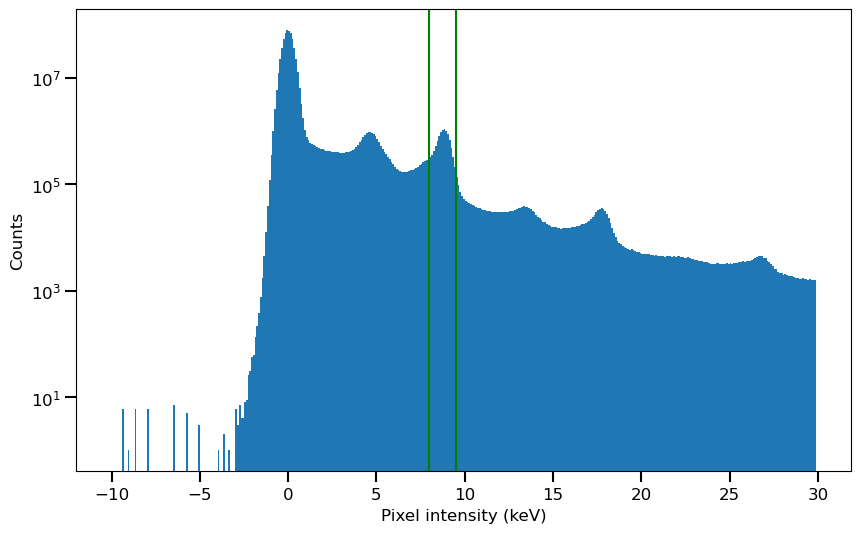

In [39]:
cdwroi = ims[:, roi[0,0]:roi[0,1],roi[1,0]:roi[1,1]]
bgroi = ims[:, (roi[0,0]-80):(roi[0,1]-80),(roi[1,0]):(roi[1,1])]
thresh1 = 8
thresh2 = 9.5
thresh3 = 16.75
thresh4 = 18.25
fig, ax = plt.subplots()
ax.hist(ims.ravel(), bins=np.arange(-10,30,0.1))
ax.axvline(thresh1, color='green')
ax.axvline(thresh2, color='green')
ax.set_xlabel('Pixel intensity (keV)')
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.show()

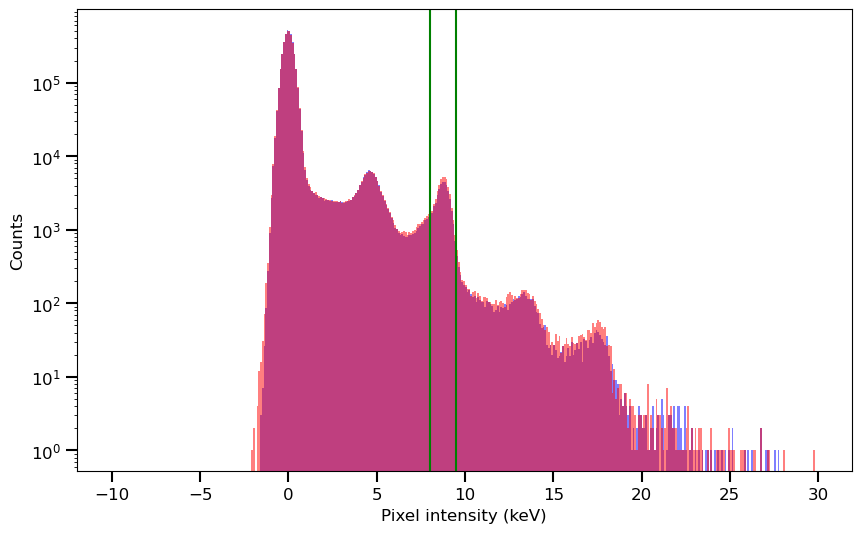

In [40]:
fig, ax = plt.subplots()
ax.hist(bgroi.ravel(), bins=np.arange(-10,30,0.1), color='blue', alpha=0.5)
ax.hist(cdwroi.ravel(), bins=np.arange(-10,30,0.1), color='red', alpha=0.5)
ax.axvline(thresh1, color='green')
ax.axvline(thresh2, color='green')
ax.set_xlabel('Pixel intensity (keV)')
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.show()

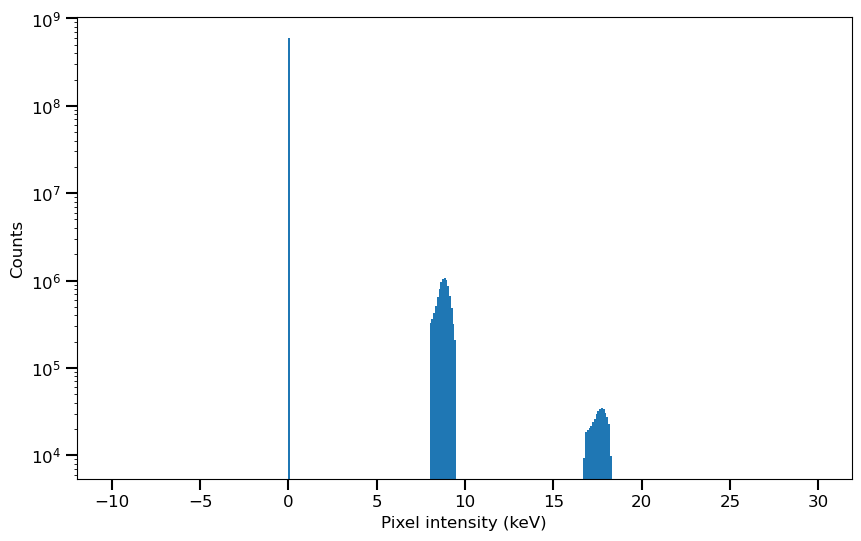

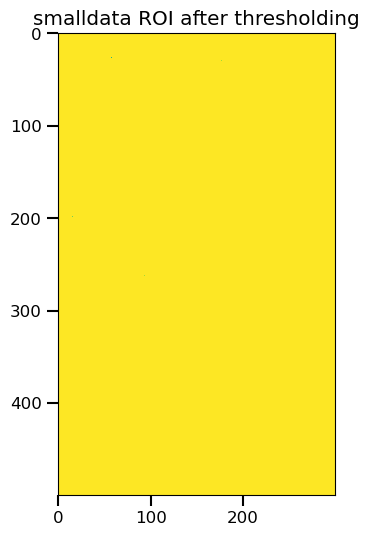

In [41]:
imgs_thresh = ims
#imgs_thresh[imgs_thresh<thresh1] = 0
imgs_thresh[(imgs_thresh<thresh1)|((imgs_thresh>thresh2)&(imgs_thresh<thresh3))|(imgs_thresh>thresh4)] = 0
#imgs_thresh[imgs_thresh>thresh4] = 0

fig, ax = plt.subplots()
ax.hist(imgs_thresh.ravel(), bins=np.arange(-10,30,0.1))
ax.set_xlabel('Pixel intensity (keV)')
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.show()

im = imgs_thresh[:,:,:].sum(axis=0)
#plt.imshow(im, clim=(0,1e3))
plt.imshow(im, clim=(0,1e2))
plt.title('smalldata ROI after thresholding')
plt.show()

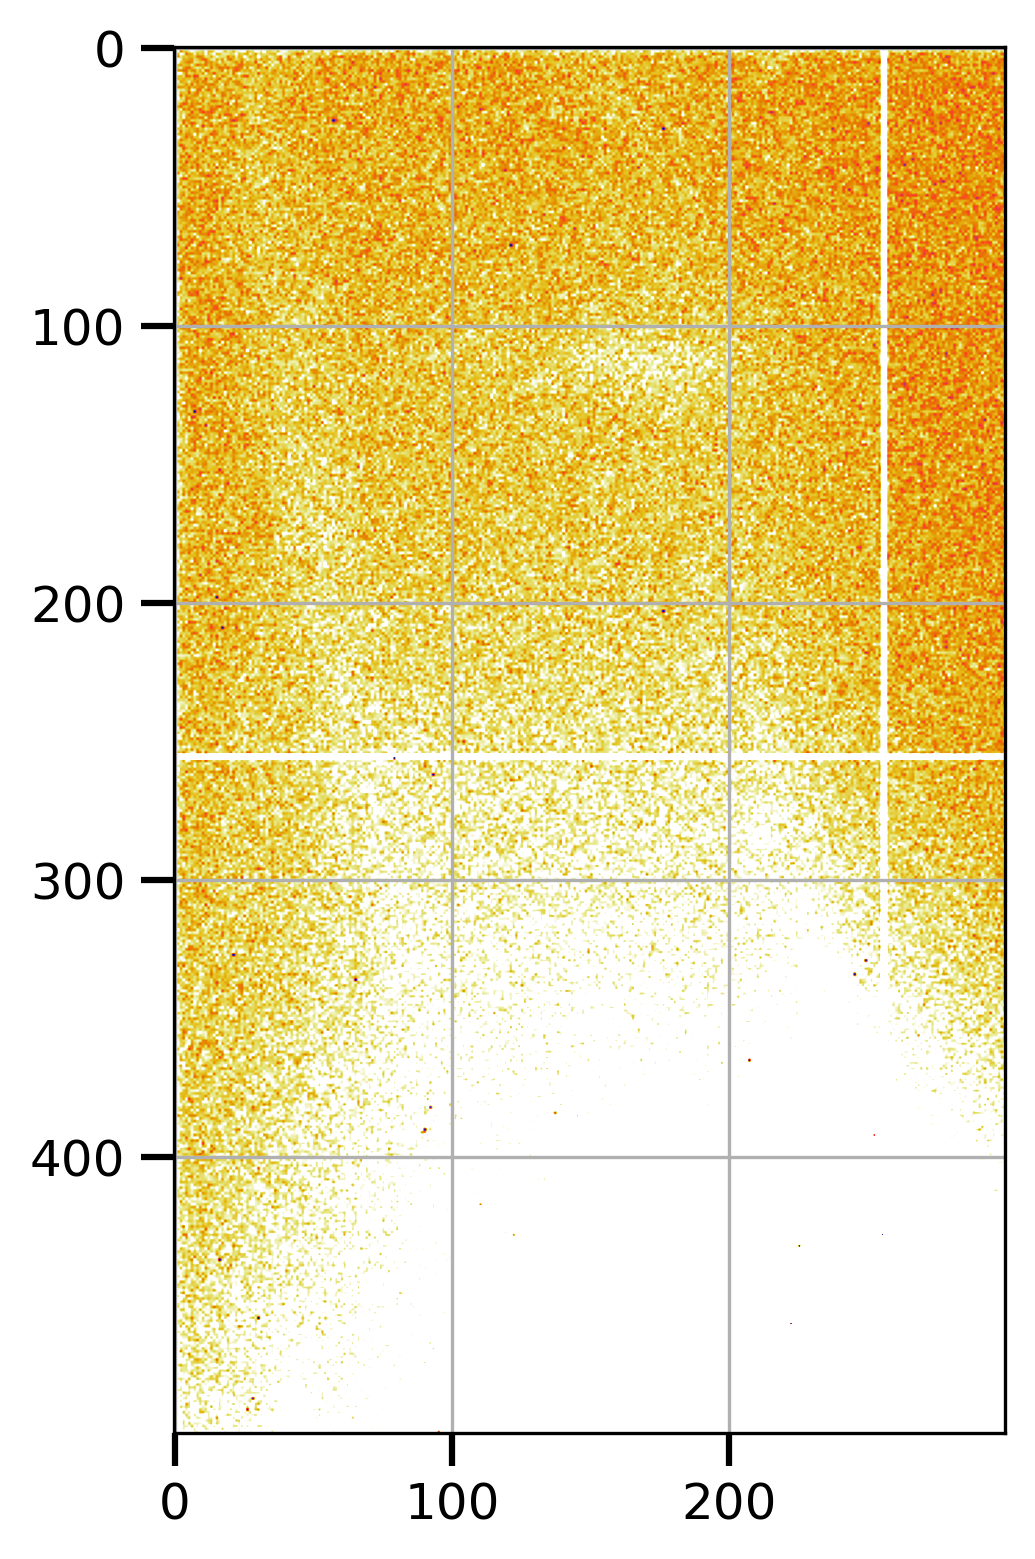

In [42]:
plt.figure(dpi=300)
plt.imshow(im, clim=(0,500), cmap='CMRmap')
plt.grid()
#plt.imshow(im, norm=LogNorm(vmin=0.01, vmax=1000000))
plt.show()

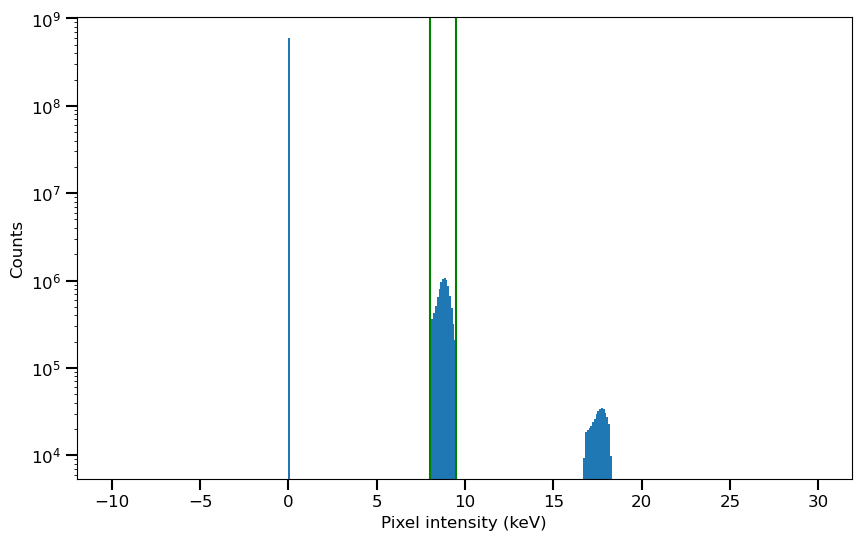

In [43]:
fig, ax = plt.subplots()
ax.hist(ims.ravel(), bins=np.arange(-10,30,0.1))
ax.axvline(thresh1, color='green')
ax.axvline(thresh2, color='green')
ax.set_xlabel('Pixel intensity (keV)')
ax.set_ylabel('Counts')
ax.set_yscale('log')
plt.show()

In [35]:
roi = np.array([[100,120],[125,175]]) # example file ROI

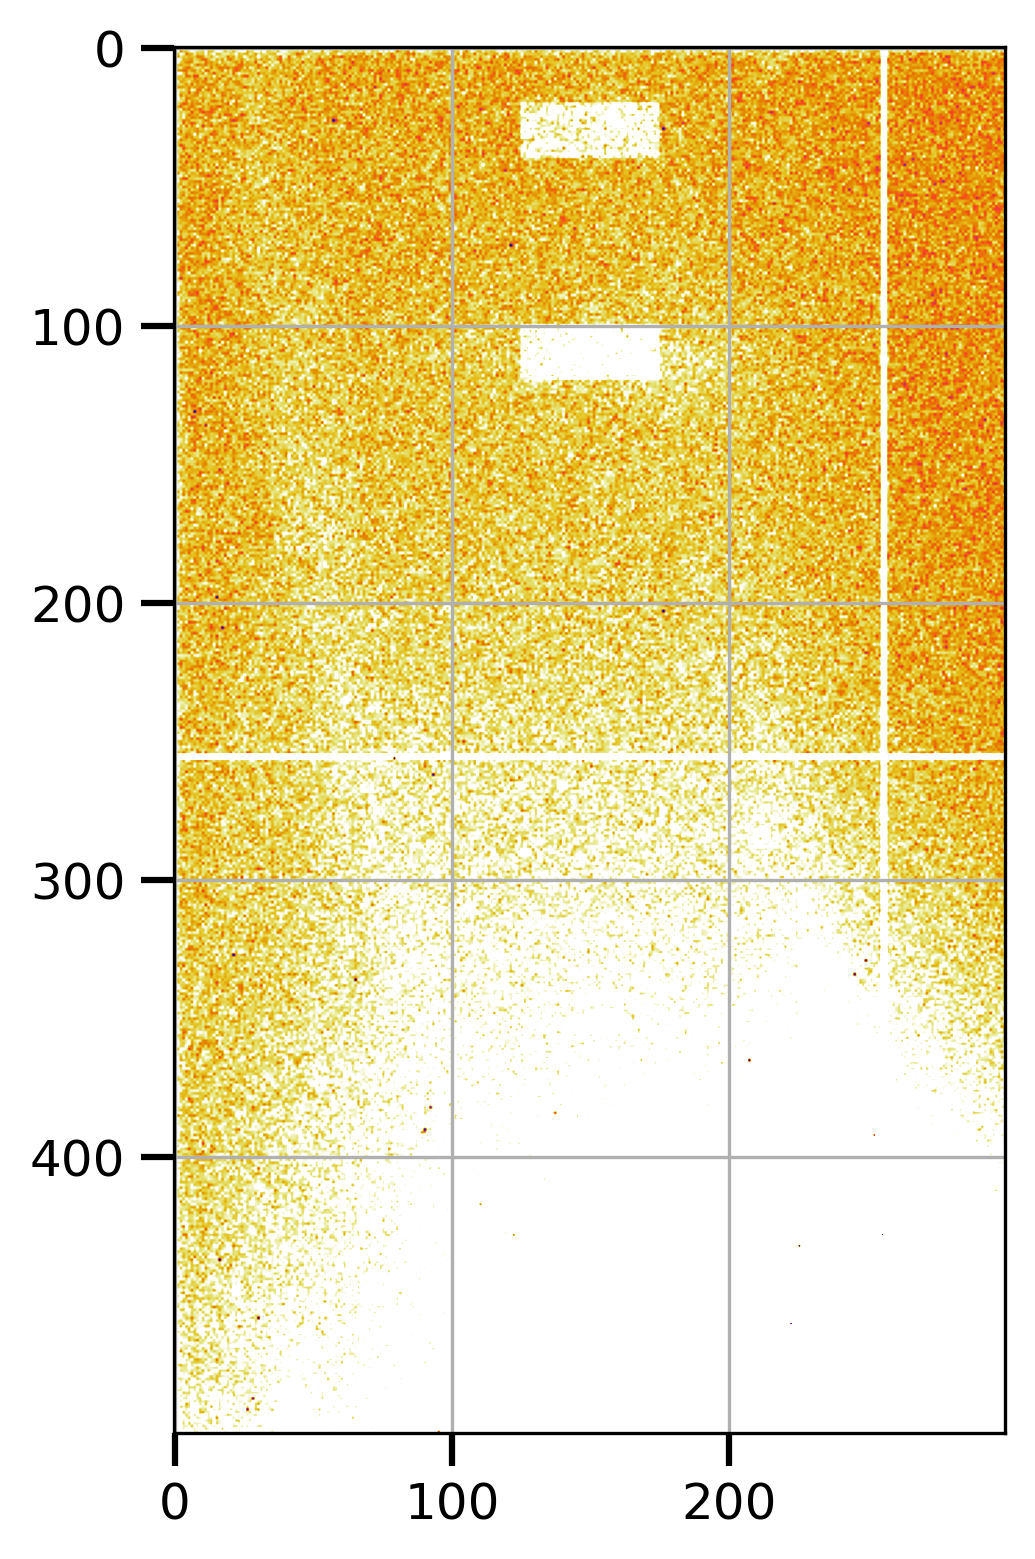

In [36]:
roi_vis = np.ones_like(im)
roi_vis[roi[0,0]:roi[0,1],roi[1,0]:roi[1,1]]=1.4
roi_vis[(roi[0,0]-80):(roi[0,1]-80),(roi[1,0]):(roi[1,1])]=1.4
plt.figure(dpi=300)
plt.imshow(im*roi_vis, clim=(0,500), cmap='CMRmap')
plt.grid()
#plt.imshow(im, norm=LogNorm(vmin=0.01, vmax=1000000))
plt.show()

# <font color='orange'> 4) ROI refinement and intensities extraction <font>

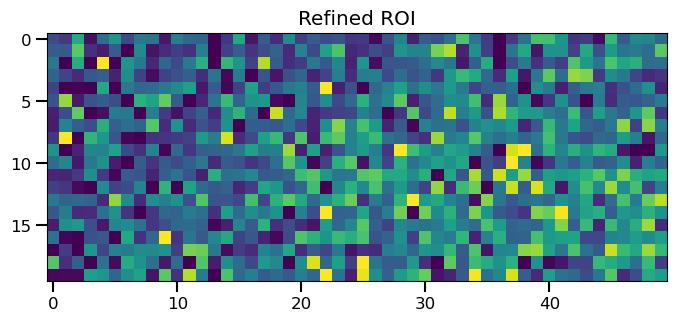

In [16]:
bragg_roi = np.asarray([420,440,200,220]) # reference bragg peak ROI

fig, ax = plt.subplots(ncols=1, figsize=(8,6))
im_roi = imgs_thresh[:,roi[0,0]:roi[0,1],roi[1,0]:roi[1,1]].sum(axis=0)
ax.imshow(im_roi, clim=(np.percentile(im_roi, 5),np.percentile(im_roi, 99)))
ax.set_title('Refined ROI')
plt.show()

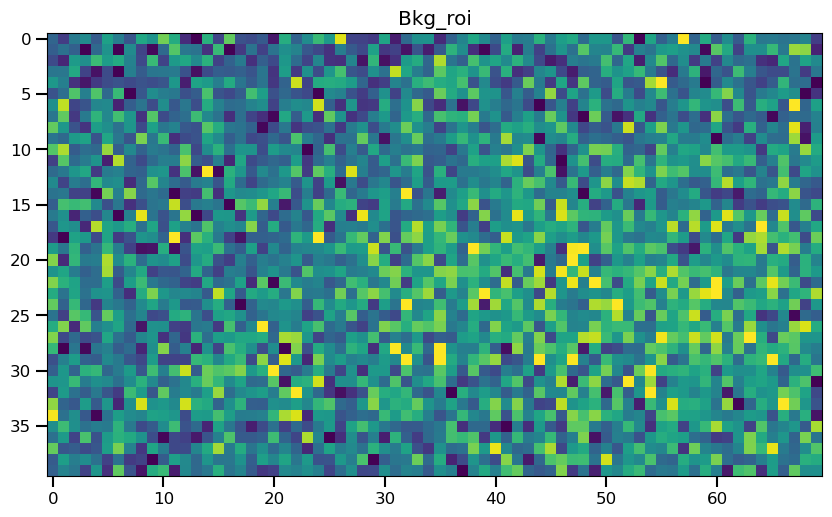

In [17]:
bkg_roi = roi + np.array([[-10,10],[-10,10]])

im_bkroi = imgs_thresh[:,bkg_roi[0,0]:bkg_roi[0,1],bkg_roi[1,0]:bkg_roi[1,1]].sum(axis=0)

plt.imshow(im_bkroi, clim=(np.percentile(im_bkroi, 1),np.percentile(im_bkroi, 99)))
plt.title('Bkg_roi')

# intensity, bkg = ana.roi_bkgRoi(rr.epix10k2M.ROI_0_area, roi, bkg_roi)
intensity, bkg = ana.roi_bkgRoi(imgs_thresh, roi, bkg_roi, safe_extend=[5,5])

## Apply thresholds and get intensities from refined ROI for all shots

Using a for loop here might be slower than loading all images in memory, but prevents out-of-memory issues for larger runs.

Apply standard calib mask to the ROI before summing intensity. Use of masked array might be better here.

In [ ]:
intensity = np.zeros(rr[dataDict['i0']].shape)
bragg_intensity = np.zeros(rr[dataDict['i0']].shape)
bkg = np.zeros(rr[dataDict['i0']].shape)

for ii,img in tqdm(enumerate(rr[dataDict['roi']])):
#     if ii>10:
#         break
    #img[img<thresh1] = 0
    #img[img>thresh2] = 0
    img[(img<thresh1)|((img>thresh2)&(img<thresh3))|(img>thresh4)] = 0
    #intensity[ii], bkg[ii] = ana.roi_bkgRoi(img*mask, roi, bkg_roi, safe_extend=[5,5])
    intensity[ii] = np.sum((img*mask)[roi[0,0]:roi[0,1],roi[1,0]:roi[1,1]])

In [ ]:
#fig, ax = plt.subplots(ncols=3, figsize=(12,5))
#ax[0].hist(intensity, bins=50)
#ax[0].set_title('Intensity')
#ax[1].hist(bkg, bins=50)
#ax[1].set_title('Bkg')
#ax[2].hist(intensity-bkg, bins=50)
#ax[2].set_title('Intensity-Bkg')
#plt.tight_layout()
#plt.show()

## Intensity - I0 correlation

In [ ]:
axs, fitRes, fitResG = ana.correlation_residual_plot(rr[dataDict['i0']], intensity, 
                                                     labels=['i0','intensity'], 
                                                     axs=None,
                                                     relative_residual=True, 
                                                     use_hist=False)

# <font color='orange'> 5) Bin data </font>

Generally the variable (motor) that is scanned is put in the `scan` field of the smalldata file. However, the fast laser delay is not properly captured and does not end up there. In case of a fast laser delay scan, the scan variable to use is `enc/lasDelay`. A few other motors are like that, please inquire the beamline staff or the data POC.

## Get the scan variable

In [ ]:
""" 
Get scan variables, accounting for the fact that fly scans need to be explicitely captured.
This mainly concerns fast delay scans (end/lasDelay) and CCM energy scan (ccm/E). Most other
scans (rocking curves, etc) are standard scan that can be found under the "scan" field.
"""
if rr.scan._v_nchildren==1: # fast dl or CCM scans are not captured as scans
    scanvar = rr[dataDict['scanvar']][:]
    scanname = dataDict['scanvar']
elif rr.scan._v_nchildren==3:
    scanvar = rr.scan.var0[:]
    scanname = [el for el in list(rr.scan._v_children) if el not in ['var0','varStep']][0]

if scanvar.mean()<1e-10:
    scanvar*=1e12

# We don't do TT correction for now since the correction is small and TT is bad
#if 'lasDelay' in scanname:
    #scanvar = scanvar + rr[dataDict['tt_corr']][:]

fig, ax = plt.subplots()
ax.hist(scanvar, bins=50)
ax.set_title('scanvar distribution')
ax.set_xlabel(scanname)
ax.set_ylabel('Counts')
plt.show()

## Apply filters

In [ ]:
filt = rr[dataDict['xon']][:] # with x-ray
lon = rr[dataDict['lon']][:] # with laser

for d in damage:
    f = rr.damage[d][:]
    filt = np.logical_and.reduce([f, filt])
    print('Damage {}: {:.1%}'.format(d, np.logical_not(f).sum()/f.size))
print('\n')
filt_lon = np.logical_and.reduce([lon, filt])
filt_loff = np.logical_and.reduce([np.logical_not(lon), filt])
print('Laser on fraction: {:.1%}'.format(lon.sum()/lon.shape[0]))

""" Apply all filters """
for n, (key,value) in enumerate(filters.items()):
    data = rr[dataDict[key]][:]
    filt_lon = np.logical_and.reduce([filt_lon, data>value[0], data<value[1]])
    if 'tt' in key: 
        continue # do not apply time tool filters to laser off
    filt_loff = np.logical_and.reduce([filt_loff, data>value[0], data<value[1]])

r1 = sum(filt_lon)/filt_lon.shape[0]
r2 = sum(filt_loff)/filt_loff.shape[0]
print('After filtering: \n\t{:.1%} of laser on shots \n\t{:.1%} of laser off shots'.format(r1,r2))

In [ ]:
lon[:20]

## Build dictionary for binning

In [ ]:
""" Create a dictionary (or pandas dataframe) with the relevant variables """
data_to_bin = {
    'scanvar': scanvar[filt_lon],
    'intensity': np.nan_to_num(intensity[filt_lon]),
    'i0': rr[dataDict['i0']][filt_lon],
}

data_to_bin_loff = {
    'scanvar': scanvar[filt_loff],
    'intensity': np.nan_to_num(intensity[filt_loff]),
    'i0': rr[dataDict['i0']][filt_loff],
}

# Define bin centers if delay scan or continuous scan
if 'lasDelay' in scanname:
    bin_centers = np.arange(28,34,0.250)
else:
    bin_centers = None

## Bin data

In [ ]:
binned_data, bin_edges = ana.weighted_bin_data(data_to_bin, bin_key='scanvar', covariance=('intensity','i0'),
                                               bin_centers=bin_centers)

binned_data_loff, bin_edges_loff = ana.weighted_bin_data(data_to_bin_loff, bin_key='scanvar', covariance=('intensity','i0'),
                                                         bin_centers=bin_centers)
'i0'
print('\n'.join(binned_data.keys()))

In [ ]:
binned_data['covariance'][10]
binned_data['covariance'].shape
binned_data['covariance'][:,0,1].shape

In [ ]:
plt.plot(filt[:100], marker='.', label='XFEL on')
plt.plot(lon[:100], marker='.', label='laser on')
plt.legend()
plt.show()

In [ ]:
plt.plot(filt_loff[:100], marker='.', label='laser off')
plt.plot(filt_lon[:100], marker='.', label='laser on')
plt.legend()
plt.show()

In [ ]:
np.sum(filt_lon)

In [ ]:
np.sum(filt_loff)

# <font color='orange'> 6) Visualization <font>

Use the covariance matrix to calculate the error bar on the mean(intensity)/mean(i0).

In [ ]:
x = binned_data['scanvar']
y = binned_data['intensity_sum']/binned_data['i0_sum']
#y = binned_data['intensity_sum']
err = ana.variance_of_ratio(binned_data['intensity_mean'], binned_data['i0_mean'], 
                            binned_data['intensity_var'], binned_data['i0_var'], 
                            binned_data['covariance'][:,0,1])
err = np.sqrt(np.abs(err))/np.sqrt(binned_data['count'])

xloff = binned_data_loff['scanvar']
yloff = binned_data_loff['intensity_sum']/binned_data_loff['i0_sum']
#yloff = binned_data_loff['intensity_sum']
errloff = ana.variance_of_ratio(binned_data_loff['intensity_mean'], binned_data_loff['i0_mean'], 
                                binned_data_loff['intensity_var'], binned_data_loff['i0_var'], 
                                binned_data_loff['covariance'][:,0,1])
errloff = np.sqrt(np.abs(errloff))/np.sqrt(binned_data_loff['count'])

fig, ax = plt.subplots(nrows=2, figsize=(10,12))
ax[0].set_title('Run {}'.format(run))
# ax[0].plot(x, y, '-o', label='laser on')
# ax[0].plot(xloff, yloff, '-o', label='laser off')
#ax[0].errorbar(x, y, yerr=err, fmt='-o', label='laser on')
ax[0].errorbar(x, y, fmt='-o', label='laser on')
#ax[0].errorbar(xloff, yloff, yerr=errloff, fmt='-o', label='laser off')
ax[0].errorbar(xloff, yloff, fmt='-o', label='laser off')
ax[0].legend()
ax[0].set_xlabel(scanname)

ax[1].set_title('(lon-loff)/loff')
err_ = np.sqrt( (1/yloff)**2*err**2 + (y/yloff**2)**2*errloff**2 ) # error propagation
ax[1].errorbar(x, (y-yloff)/yloff, yerr=err_, fmt='-o')
ax[1].set_xlabel(scanname)
# ax[1].set_xlim(-2,10)
plt.tight_layout()
plt.show()

In [ ]:
""" A view on the errorbars """
fig, ax = plt.subplots(nrows=3, figsize=(10,12))
ax[0].set_title('Laser on error')
ax[0].plot(err)
ax[1].set_title('Laser off error')
ax[1].plot(errloff)
ax[2].set_title('Ratio error')
ax[2].plot(err_)
plt.tight_layout()
plt.show()

# <font color='orange'> 7) Save binned data </font>

### Save binned data to csv files

Only for 1-d data (cannot save the covariance)

In [ ]:
# from pandas import DataFrame

# df = DataFrame.from_dict(binned_data)
# df.to_csv('./binned/r{}_lon.csv'.format(run), index=False)

# df = DataFrame.from_dict(binned_data_loff)
# df.to_csv('./binned/r{}_loff.csv'.format(run), index=False)

### Save binned data to hdf5 files

Can save arbitrary sized data

In [ ]:
# fname = f'binned/r{run}_lon.h5'
# ana.dict_to_h5(binned_data, fname)

# fname = f'binned/r{run}_loff.h5'
# ana.dict_to_h5(binned_data_loff, fname)

# open file for read
# tt = tables.File(fname).root

In [ ]:
good_shots = np.asarray(rr[dataDict['i0']]) > 200
i_zero = np.asarray(rr[dataDict['i0']])[good_shots]
tt_amplitude = np.asarray(rr[dataDict['tt_amp']])[good_shots]

plt.figure()
plt.hist2d(i_zero, tt_amplitude, bins=(200,200), cmap='jet', norm=LogNorm())
plt.xlabel("ipm2 I0")
plt.ylabel("TT amplitude")
plt.ylim(0,0.2)
plt.show()